# APA - Problema 2.3

## Imports

In [30]:
!pip install apafib --upgrade  --quiet
!pip install pmlb --upgrade  --quiet

In [1]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from yellowbrick.classifier.rocauc import roc_auc
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve

import warnings

sns.set_theme()
sns.set_palette(sns.color_palette("tab10"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [2]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results = pd.DataFrame()

cls = ['0', '1', '2', '3', '4', '5', '6', '7']

## Obtenció del conjunt de dades

In [3]:
from apafib import load_food
data = load_food()
print(f"Valors faltants: {data.isna().sum().sum()}")
data.describe(include="all").T

Valors faltants: 0


,count,mean,std,min,25%,50%,75%,max
Caloric Value,1622.0,247.187423,366.884720,0.0,61.00000,148.0000,318.50000,6077.000
Fat,1622.0,11.074435,28.313218,0.0,0.40000,3.1000,11.27500,550.700
Saturated Fats,1622.0,3.855933,10.276224,0.0,0.07800,0.8000,3.60000,167.600
Monounsaturated Fats,1622.0,4.648184,13.378307,0.0,0.07800,0.9000,4.20000,291.100
Polyunsaturated Fats,1622.0,2.033573,5.174454,0.0,0.08175,0.5000,1.90000,64.400
Carbohydrates,1622.0,19.434917,29.576650,0.0,0.10000,6.0000,29.00000,225.800
Sugars,1622.0,4.695364,11.471998,0.0,0.00000,0.0000,3.40000,97.700
Protein,1622.0,16.496890,32.263619,0.0,1.20000,5.5500,19.55000,560.300
Dietary Fiber,1622.0,2.208032,5.580442,0.0,0.00000,0.0000,1.90000,58.600
Cholesterol,1622.0,62.432792,162.529854,0.0,0.00000,2.5000,59.50000,1936.700


In [4]:
X = data.drop(columns=["Class"])
y = data["Class"]
y.value_counts()

Class
1    306
5    284
2    244
0    195
3    166
4    154
7    142
6    131
Name: count, dtype: int64

## A: Divisió, Exploració, PCA i t-SNE

### Divisió i Normalizació de les dades

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [6]:
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

### Exploració mínima de les dades

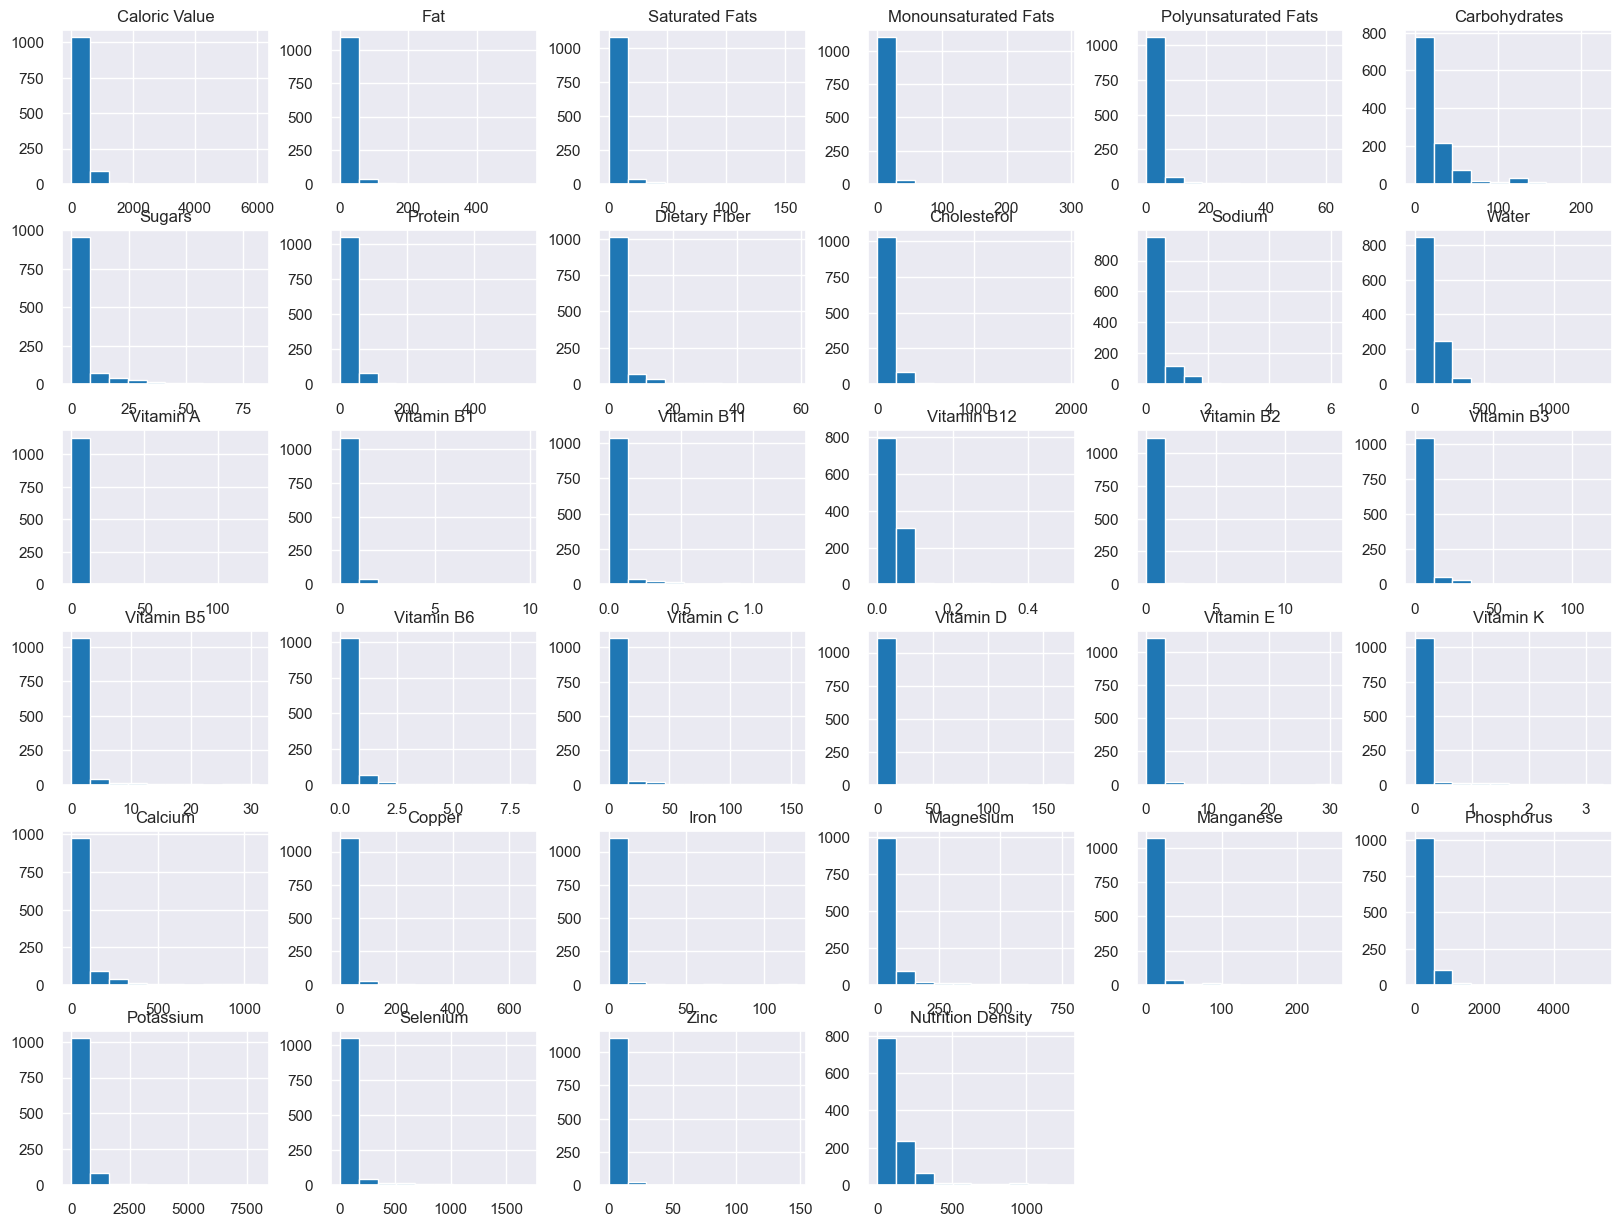

In [7]:
X_train.hist(figsize=(20, 15));

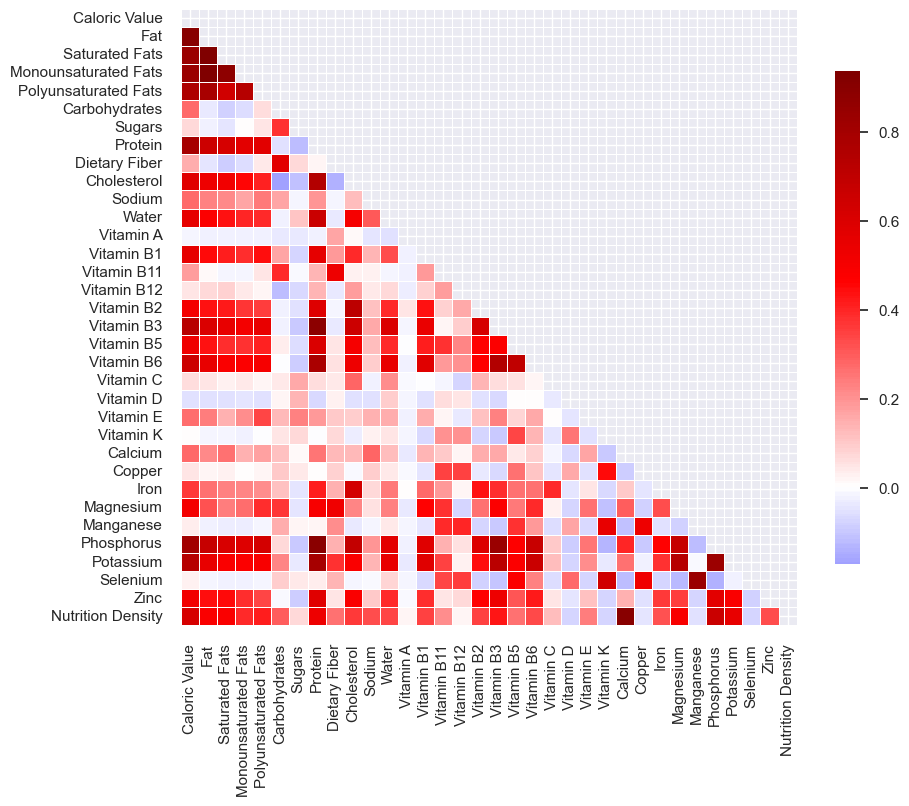

In [8]:
corr = X_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8});

Observant la matriu de correlacions podem veure com:
- Els greixos estan molt correlacionats entre ells i amb el valor caloric, la qual cosa té bastant sentit ja que els greixos tenen bastantes calories en genereal.
- Alguns minerals com el fósfor i el potassi estan bastant correlacionats amb amb algunes vitamines, donant a entendre que aquests minerals proporcionen les vitamines corresponents.
- Alguns minerals com per exemple el potassi i el magnessi mostren una forta correlació entre ells, segurament perquè normalment es troben en tipus d'aliments similar.
- Hi ha poques correlacions negatives, i les que hi ha són bastant lleugeres, alguna que destaca és la correlació negativa entre els carbohidrats i el colesterol, la qual cosa té bastant sentit perquè normalment els aliments que porten més colesterol són aliments d'origen animal, que solen tenir menys carbohidrats, ja que aquests es troben principalment en aliments d'origen vegetal com cereals, llegums, fruites i verdures.

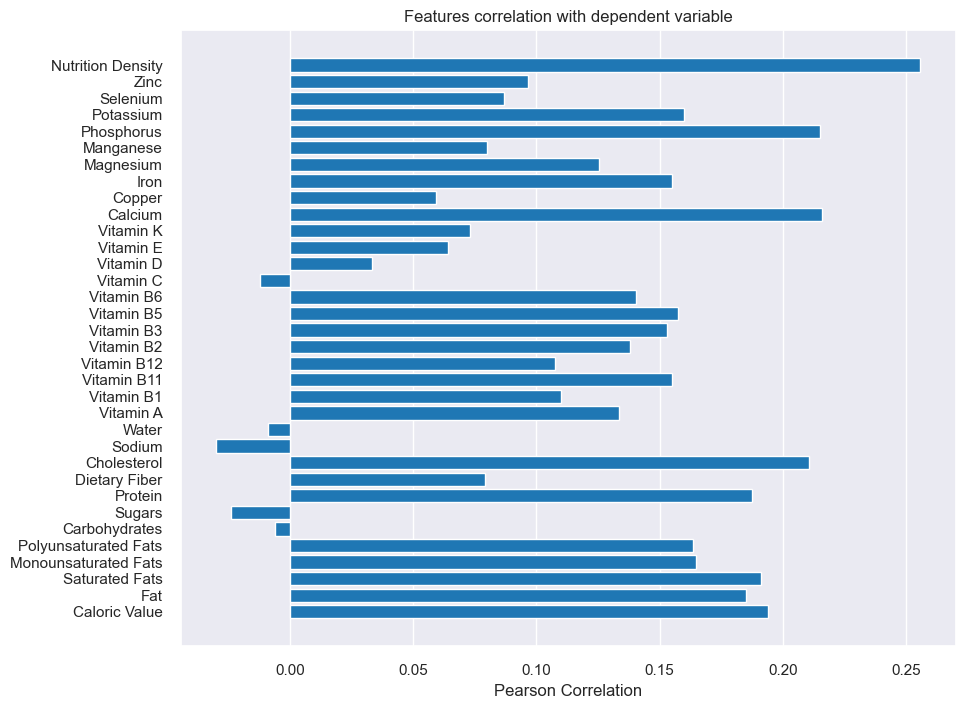

In [10]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train, y_train, labels=list(X_train.columns),method='pearson');

Observant la correlació de pearson podem destacar el pes de la densitat nutricional la qual cosa té bastant sentit ja que els eliments més nutritius solen ser millors. També podem veure com el sucre i el sodi solen empitjorar lleugerament la qualitat dels eliments ja que tenen una correlació negativa amb la varible objectiu.

### PCA

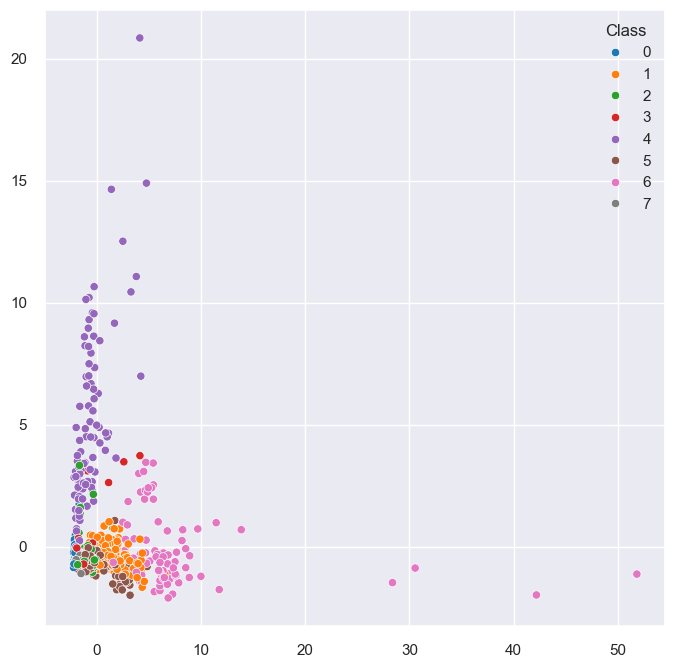

In [11]:
pca = PCA().fit(X_train_s);
X_pca = pca.fit_transform(X_train_s)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train, palette='tab10');

En aquest cas, podem observar una certa separabilitat entre les classes 1, 4 i 6. No obstant això, la resta de classes no presenten una separabilitat clara, resultant en una solució poc satisfactòria.

### t-SNE

Utilitzarem el t-SNE inicialitzat amb PCA per tal d’obtenir una solució més precisa.

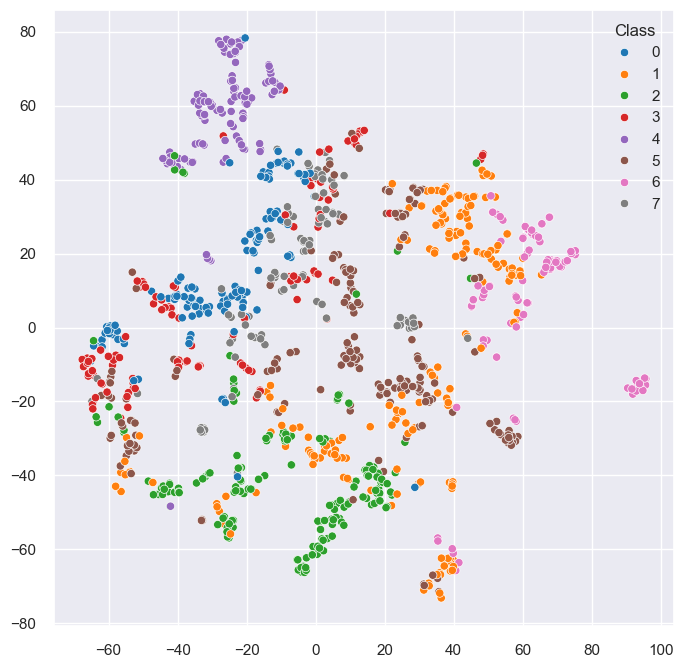

In [12]:
X_tsne= TSNE(n_components=2, perplexity=10,max_iter=2000, init='pca').fit_transform(X_train_s)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_train, palette='tab10');

Amb el t-SNE observem una gran millora en la separabilitat entre les classes, encara que les classes 5 i 3 mostren una major dispersió, i per tant, certa barreja amb altres classes.

##B: Naïve Bayes

In [13]:
gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb, X_train_s, y_train, cv=10))
print(gnb.best_score_)

0.7551234280391245


In [14]:
gnb_model = GaussianNB().fit(X_train_s, y_train)

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=X.columns
means

Priors: [0.11982379 0.18854626 0.15066079 0.10220264 0.09515419 0.1753304
 0.08105727 0.08722467]
Means:



,Caloric Value,Fat,Saturated Fats,Monounsaturated Fats,Polyunsaturated Fats,Carbohydrates,Sugars,Protein,Dietary Fiber,Cholesterol,...,Calcium,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Zinc,Nutrition Density
0,-0.641573,-0.384021,-0.374474,-0.328573,-0.369385,-0.594991,-0.337920,-0.490802,-0.367622,-0.368781,...,-0.436792,-0.148383,-0.312085,-0.494667,-0.229981,-0.549021,-0.569083,-0.228180,-0.298608,-0.679566
1,0.361397,0.133664,0.082560,0.078828,0.114663,0.485181,0.067148,0.335794,0.201749,0.085776,...,0.094258,-0.185839,0.118722,0.510210,-0.213385,0.414834,0.456982,-0.252622,0.307731,0.268999
2,-0.348974,-0.319513,-0.328963,-0.295547,-0.292444,0.019216,0.295768,-0.407326,-0.033400,-0.351743,...,-0.250855,-0.149147,-0.180753,-0.282128,-0.212866,-0.415679,-0.255205,-0.225779,-0.234139,-0.299525
3,-0.422869,-0.257534,-0.182046,-0.124662,-0.135201,-0.382032,-0.072605,-0.416423,-0.352858,-0.175473,...,-0.417668,-0.177910,-0.236062,-0.458292,-0.227919,-0.474690,-0.527367,-0.219292,-0.285057,-0.581959
4,-0.126485,-0.148298,-0.157553,-0.158634,-0.134586,0.112646,0.126891,-0.118569,0.278978,-0.188833,...,-0.472764,1.643276,-0.308780,-0.503074,2.154088,-0.566568,-0.282152,2.291216,-0.329843,-0.431037
5,0.071034,0.097841,0.176044,0.121018,0.076070,0.115751,0.117003,-0.094437,-0.229124,-0.018761,...,0.634488,-0.191188,-0.076398,-0.166043,-0.248297,-0.000390,-0.265643,-0.252655,-0.108398,0.488956
6,1.824438,1.435728,1.282276,1.221706,1.310917,0.401694,-0.124629,1.989168,0.926139,1.775307,...,0.681586,-0.160069,1.635740,2.004612,-0.200006,2.282089,2.325573,-0.252281,1.411038,1.426302
7,-0.501829,-0.276846,-0.256120,-0.267991,-0.301185,-0.545821,-0.364531,-0.389476,-0.164378,-0.271716,...,-0.074064,-0.187976,-0.268765,-0.379336,-0.253025,-0.370179,-0.466683,-0.250742,-0.250107,-0.286757


Podem veure que una bona part de les estimacions és bastant similar als valors reals, però també hi ha certs paràmetres que tenen una desviació considerable.

In [16]:
print(classification_report(y_test, gnb_model.predict(X_test_s), target_names=['CLASS_0', 'CLASS_1', 'CLASS_2', 'CLASS_3', 'CLASS_4', 'CLASS_5', 'CLASS_6', 'CLASS_7']))
results = save_results(gnb_model, X_test_s, y_test, 'GNB', results)

              precision    recall  f1-score   support

     CLASS_0       0.90      0.92      0.91        59
     CLASS_1       0.79      0.82      0.80        92
     CLASS_2       0.86      0.70      0.77        73
     CLASS_3       0.75      0.24      0.36        50
     CLASS_4       0.80      0.89      0.85        46
     CLASS_5       0.72      0.81      0.76        85
     CLASS_6       0.76      0.79      0.78        39
     CLASS_7       0.57      0.91      0.70        43

    accuracy                           0.76       487
   macro avg       0.77      0.76      0.74       487
weighted avg       0.78      0.76      0.75       487



Els resultats no han sigut tant positius com podriem esperar, algunes classes han tingut encerts per sobre del 80%, pero la majoria estan per sota, fent que no siguin uns resultats acceptables, tot i que pot ser un bon punt de partida per a comparar-ho més tard amb altres models de predicció .

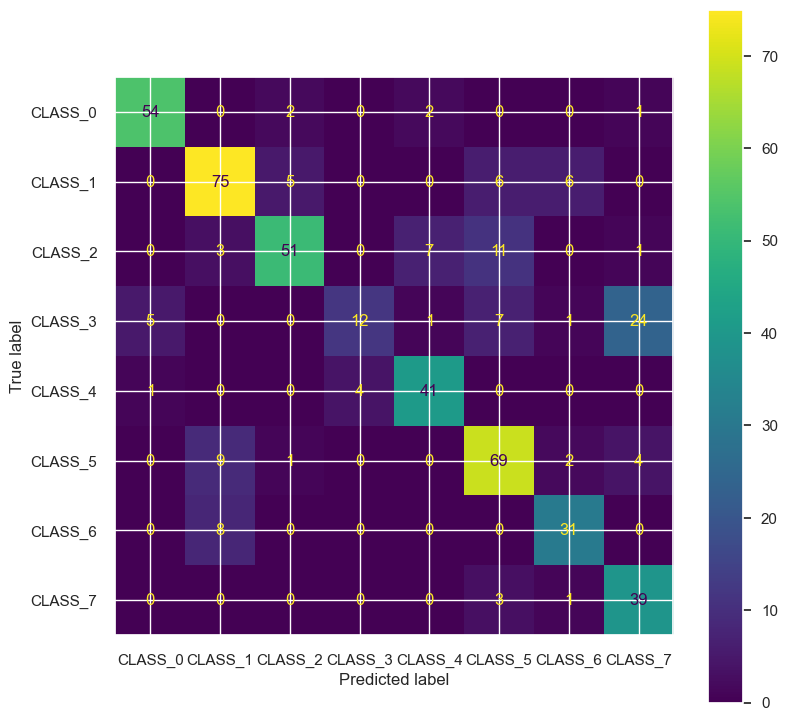

In [17]:
plt.figure(figsize=(9,9));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test_s,y_test, display_labels=['CLASS_0', 'CLASS_1', 'CLASS_2', 'CLASS_3', 'CLASS_4', 'CLASS_5', 'CLASS_6', 'CLASS_7'], ax=plt.subplot());

En la gràfica es pot veure que un subconjunt considerable dels errors son prediccions de CLASS_7 que haurien de ser de CLASS_3. Per contra, la CLASS_0 sembla tenir bones prediccions.

## C: Discriminant lineal i regresió logística

### Discriminant lineal (LDA)

Obtenim l'error de validació creuada utilitzant les dades d'entrenament.

In [18]:
lda = LinearDiscriminantAnalysis()
lda.best_score_ = np.mean(cross_val_score(lda,X_train_s,y_train,cv=10))
print(lda.best_score_)

0.6458779692594318


L'encert del model és bastant dolent. En aquest cas, aplicarem el model amb totes les dades del conjunt d'entrenament.

Priors: [0.11982379 0.18854626 0.15066079 0.10220264 0.09515419 0.1753304
 0.08105727 0.08722467]
Means:

Intercepts:
Explained Variance Ratio
Coefs:


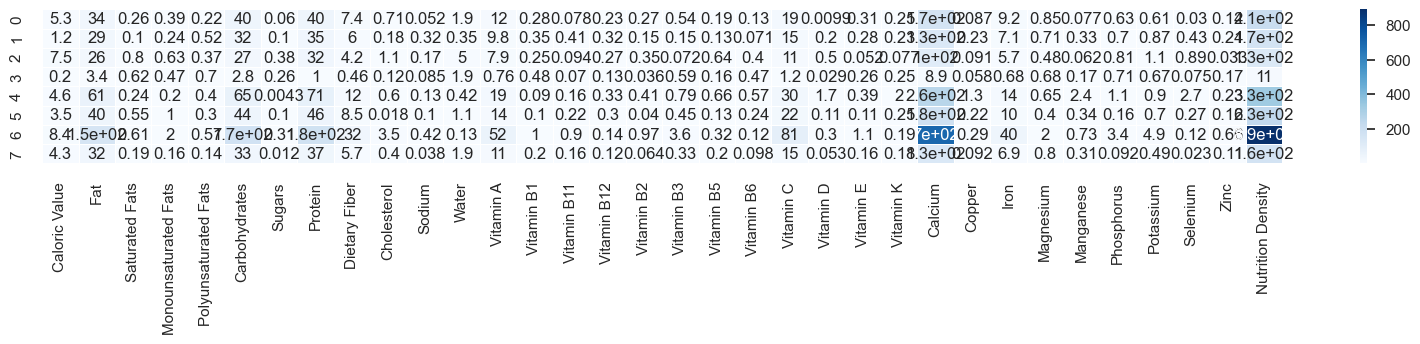

In [19]:
lda_model = LinearDiscriminantAnalysis().fit(X_train_s, y_train)

print('Priors:', lda_model.priors_)
print('Means:\n')
means =pd.DataFrame(lda_model.means_)
means.columns=X_train.columns
means

print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
intercepts

print('Explained Variance Ratio')
pd.DataFrame(lda_model.explained_variance_ratio_ )

print('Coefs:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = X_train.columns
# coefs.T

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

Amb aquesta gràfica podem observar els valors més importants per a cada classe. En aquest model destaca el pes del calci i de la densitat de la nutrició.

In [20]:
print(classification_report(y_test, lda_model.predict(X_test_s), target_names=['0', '1', '2', '3', '4', '5', '6', '7']))
results = save_results(lda_model, X_test_s, y_test, 'LDA', results)

              precision    recall  f1-score   support

           0       0.36      1.00      0.53        59
           1       0.78      0.73      0.75        92
           2       0.85      0.92      0.88        73
           3       0.71      0.30      0.42        50
           4       1.00      0.72      0.84        46
           5       0.68      0.56      0.62        85
           6       0.97      0.72      0.82        39
           7       0.75      0.07      0.13        43

    accuracy                           0.66       487
   macro avg       0.76      0.63      0.62       487
weighted avg       0.75      0.66      0.65       487



Podem observar que la precisió general és bastant dolenta, especialment en la classe 0. Moltes classes presenten una precisió baixa i un recall alt, o viceversa. Això indica una confusió a l'hora de classificar, ja que algunes classes acumulen més valors dels que haurien, generant molts falsos positius i provocant que altres classes tinguin un recall més baix.

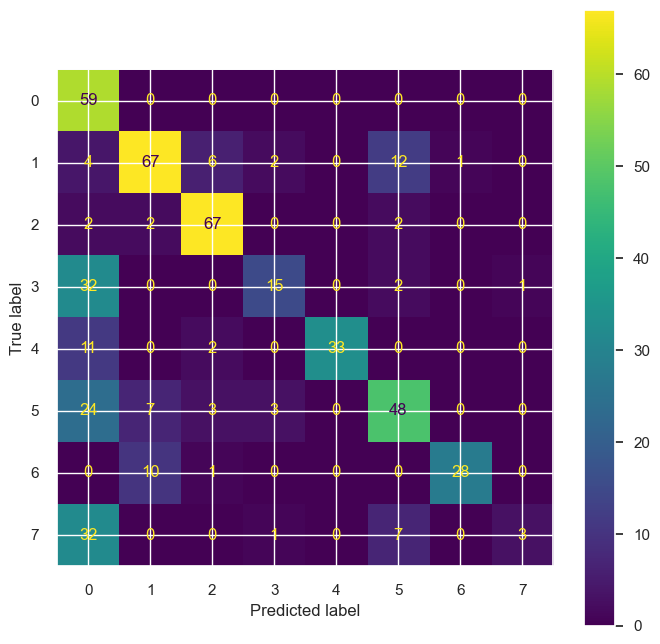

In [21]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda_model, X_test_s,y_test, display_labels=['0', '1', '2', '3', '4', '5', '6', '7'], ax=plt.subplot());

Amb aquesta gràfica reafirmem el que s'ha mencionat anteriorment, mostrant una gran confusió entre classes, on no es penalitza tant que elements de moltes classes es classifiquin a la classe 0. Això genera el alt recall de la calsse 0, però també la precisió tant baixa que aquesta té.

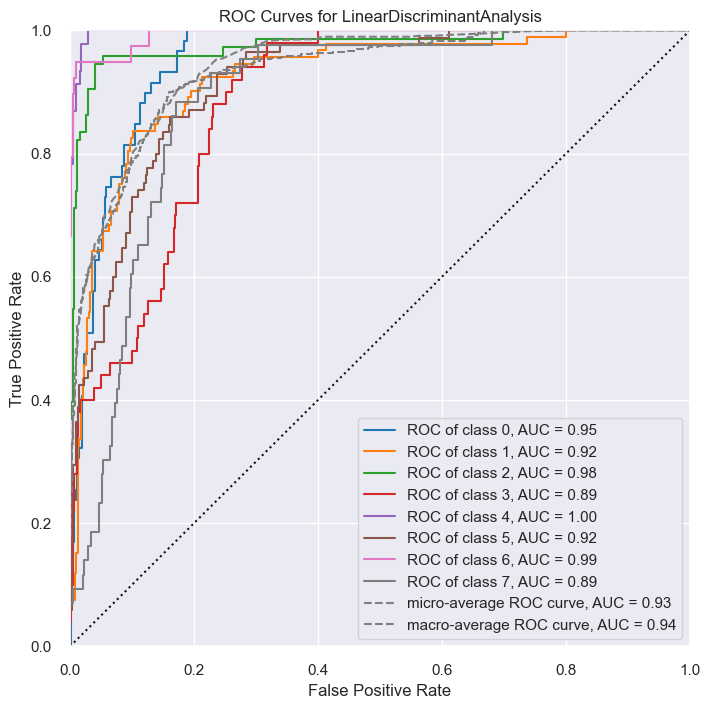

In [22]:
cls = ['0', '1', '2', '3', '4', '5', '6', '7']
plt.figure(figsize=(8,8));
roc_auc(lda_model, X_train_s, y_train, X_test_s, y_test, classes=cls);

Finalment, podem observar que algunes poques classes estan separades de la resta i mostren un alt percentatge de falsos positius.

### Regressió logística

Apliquem la regressió logística amb L1 i saga.

In [23]:
lr = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
param_lr = {'C': 10**np.linspace(-3, 3, 5, endpoint=True)}

lr_gs =  GridSearchCV(lr,param_lr,cv=5, n_jobs=-1, refit=True)
lr_gs.fit(X_train_s, y_train);

In [24]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
2,{'C': 1.0},0.877533,1
3,{'C': 31.622776601683793},0.877533,2
4,{'C': 1000.0},0.876652,3
1,{'C': 0.03162277660168379},0.690749,4
0,{'C': 0.001},0.185903,5


Escollim els hiperparàmetres que han donat un score més alt.

Coefs:


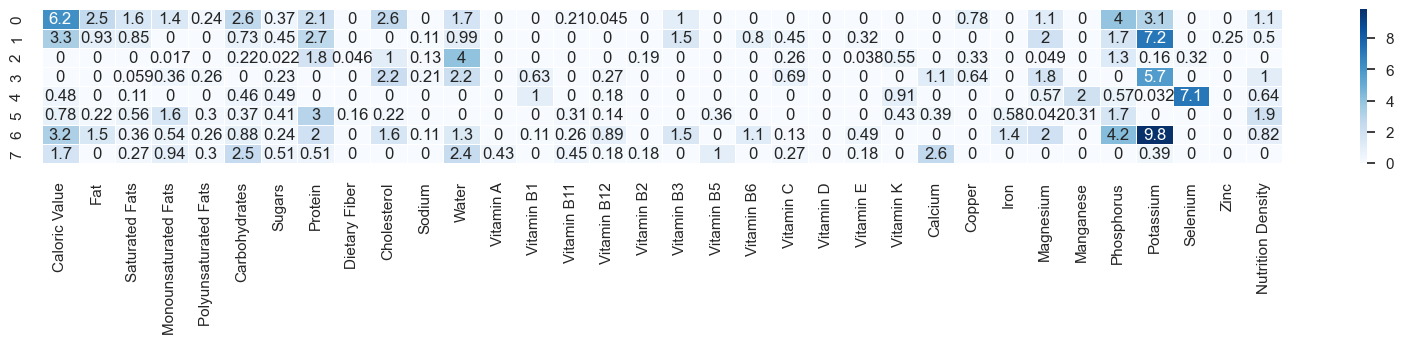

In [25]:
print('Coefs:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

Podem observar els atributs més importants per a cada classe, on es mostra una gran diferència respecte al model anterior. En aquest model el potasi és la variable amb més pes, encara que algunes clases li donen un pes alt al valor caloric o al seleni.

In [26]:
print(classification_report(y_test, lr_gs.predict(X_test_s), target_names=['0', '1', '2', '3', '4', '5', '6', '7']))
results = save_results(lr_gs, X_test_s, y_test, 'Logistic', results)

              precision    recall  f1-score   support

           0       0.73      0.98      0.84        59
           1       0.87      0.91      0.89        92
           2       0.94      0.90      0.92        73
           3       0.88      0.72      0.79        50
           4       0.98      0.89      0.93        46
           5       0.90      0.87      0.89        85
           6       0.97      0.87      0.92        39
           7       0.78      0.74      0.76        43

    accuracy                           0.87       487
   macro avg       0.88      0.86      0.87       487
weighted avg       0.88      0.87      0.87       487



Es pot observar que la classe amb més precisió ha sigut la 4, mentre que la que menys precisió té és la 0. Una curiositat és el fet que la classe 0, tot i tenir una precisió molt baixa, mostra que agafa més valors dels que hauria, generant molts falsos positius.

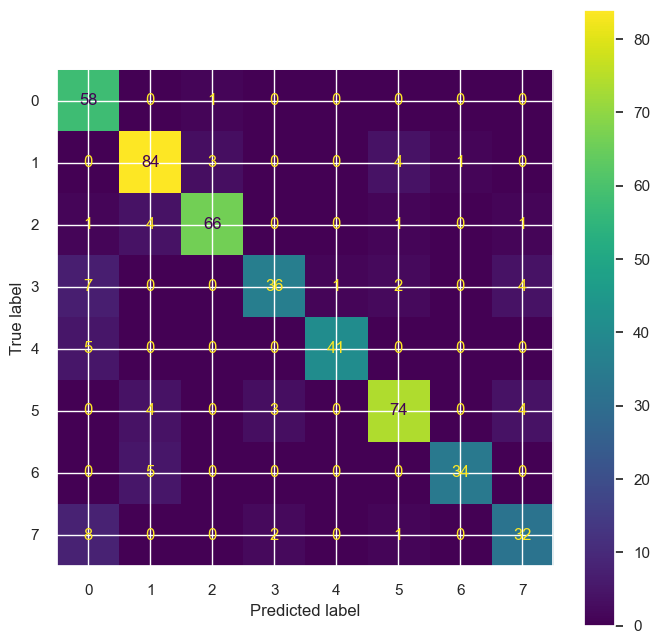

In [27]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_s,y_test, display_labels=['0', '1', '2', '3', '4', '5', '6', '7'], ax=plt.subplot());

Aquí es pot veure una distribució correcta, ja que no hi ha gaire confusió entre classes. També mostra que, tot i ser de forma mínima, varies classes mostren un petit valor positiu per la classe 0, això genera que es classifiquin erròniament alguns valors, causant la baixada de precisió anterior. Tot i això, aquest sembla un bon model per aquest conjunt de dades.

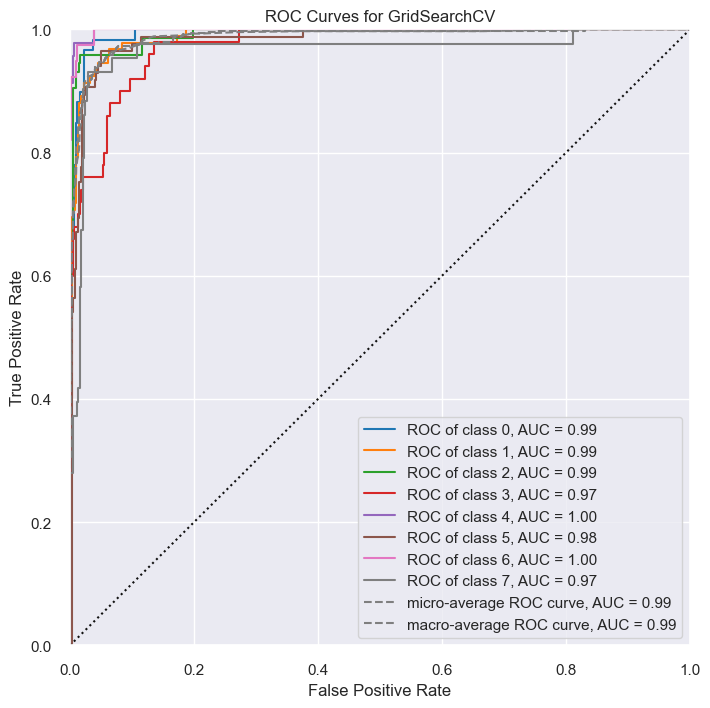

In [28]:
plt.figure(figsize=(8,8));
roc_auc(lr_gs, X_train_s, y_train, X_test_s, y_test, classes=cls);

Amb aquesta gràfica podem observar que el resultat obtingut és molt bo, ja que el percentatge de falsos positius és molt baix. Només la classe 3 mostra una diferència en comparació amb la resta, tot i que segueix sent un bon resultat.

## D: Recursive Feature Elimination

In [29]:
from sklearn.feature_selection import RFECV

In [37]:
selector_logistic = RFECV(estimator=lr_gs.best_estimator_, step=2, cv=3, scoring='accuracy', n_jobs=-1)
selector_logistic.fit(X_train_s, y_train)
X_train_logistic_reduced = selector_logistic.transform(X_train_s)
X_test_logistic_reduced = selector_logistic.transform(X_test_s)
selected_features_logistic = X.columns[selector_logistic.support_]
X_train_logistic_reduced_df = pd.DataFrame(X_train_logistic_reduced, columns=selected_features_logistic)
X_train_logistic_reduced_df.head()

RFECV(cv=3,
      estimator=LogisticRegression(C=np.float64(1.0), max_iter=10000,
                                   penalty='l1', solver='saga'),
      n_jobs=-1, scoring='accuracy', step=2)

,Caloric Value,Protein,Cholesterol,Water,Phosphorus,Potassium,Selenium,Nutrition Density
0,-0.555452,-0.345399,-0.243094,-0.644242,-0.400914,-0.441318,-0.252370,-0.654141
1,-0.022941,-0.379636,-0.360987,1.045138,-0.368921,0.629335,-0.252315,0.131175
2,-0.475850,-0.510356,-0.376468,-0.831951,-0.567696,-0.600868,-0.252912,-0.735027
3,-0.629564,-0.510356,-0.376468,-0.831753,-0.567696,-0.600683,-0.252754,-0.702692
4,0.311937,-0.351624,-0.352652,-0.512185,0.262360,-0.266556,-0.252620,0.266415


Creem ara un model amb els atributs reduïts

In [32]:
lr_reduced= LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
param_lr_reduced = {'C': 10**np.linspace(-3, 3, 5, endpoint=True)}
lr_gs_reduced =  GridSearchCV(lr_reduced,param_lr_reduced,cv=5, n_jobs=-1, refit=True)
lr_gs_reduced.fit(X_train_logistic_reduced, y_train);

In [33]:
show_html(pd.DataFrame(lr_gs_reduced.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
3,{'C': 31.622776601683793},0.900441,1
4,{'C': 1000.0},0.899559,2
2,{'C': 1.0},0.895154,3
1,{'C': 0.03162277660168379},0.667841,4
0,{'C': 0.001},0.182379,5


Coefs:


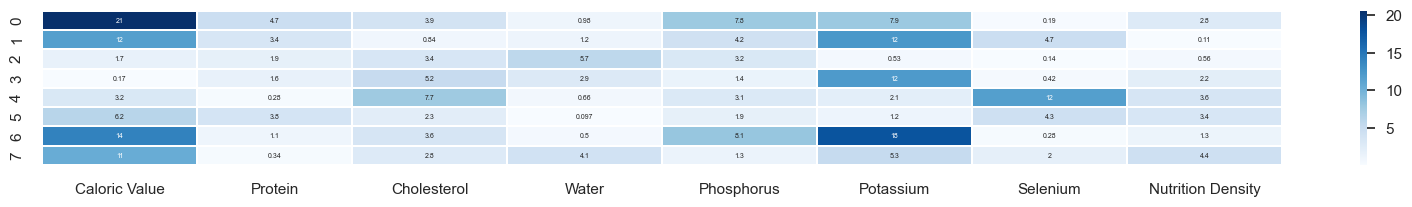

In [34]:
print('Coefs:')
X_train_logistic_reduced_dataFrame = pd.DataFrame(X_train_logistic_reduced)
coefs = pd.DataFrame(lr_gs_reduced.best_estimator_.coef_)
coefs.columns = X_train_logistic_reduced_df.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.20,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':5});

Podem veure que ara els atributs més importants segueixen sent més o menys els mateixos però ara els seus pesos s'han vist modificats (ex: a laclase 0, Caloric value tenia un pes de 6.2 i ara té un pes de 21).

## E: KNN

In [ ]:
knn =  KNeighborsClassifier()
param = {'n_neighbors':[1, 3, 5, 7, 11, 15, 17, 19, 21],
          'weights':['distance', 'uniform'],
          'metric': ['l2', 'l1', 'cosine']}
knn_gs =  GridSearchCV(knn,param,cv=5, n_jobs=-1)
knn_gs.fit(X_train_s, y_train);

In [ ]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
22,"{'metric': 'l1', 'n_neighbors': 5, 'weights': 'distance'}",0.840529,1
19,"{'metric': 'l1', 'n_neighbors': 1, 'weights': 'uniform'}",0.837004,2
18,"{'metric': 'l1', 'n_neighbors': 1, 'weights': 'distance'}",0.837004,2
24,"{'metric': 'l1', 'n_neighbors': 7, 'weights': 'distance'}",0.834361,4
20,"{'metric': 'l1', 'n_neighbors': 3, 'weights': 'distance'}",0.833480,5


Els paràmetres que donen millor resultat són: metric='l1', n_neighbors=5, weights='distance', amb un mean test score de $\approx$ 0.84

In [ ]:
print(classification_report(y_test, knn_gs.predict(X_test_s), target_names=cls))
results = save_results(knn_gs, X_test_s, y_test, 'KNN', results)

              precision    recall  f1-score   support

           0       0.79      0.95      0.86        59
           1       0.88      0.76      0.81        92
           2       0.86      0.95      0.90        73
           3       0.74      0.78      0.76        50
           4       0.97      0.83      0.89        46
           5       0.83      0.85      0.84        85
           6       0.94      0.85      0.89        39
           7       0.76      0.74      0.75        43

    accuracy                           0.84       487
   macro avg       0.85      0.84      0.84       487
weighted avg       0.84      0.84      0.84       487



Els resultats obtinguts semblen prou bons amb la majoria de classes amb encerts d'almenys un 80%.

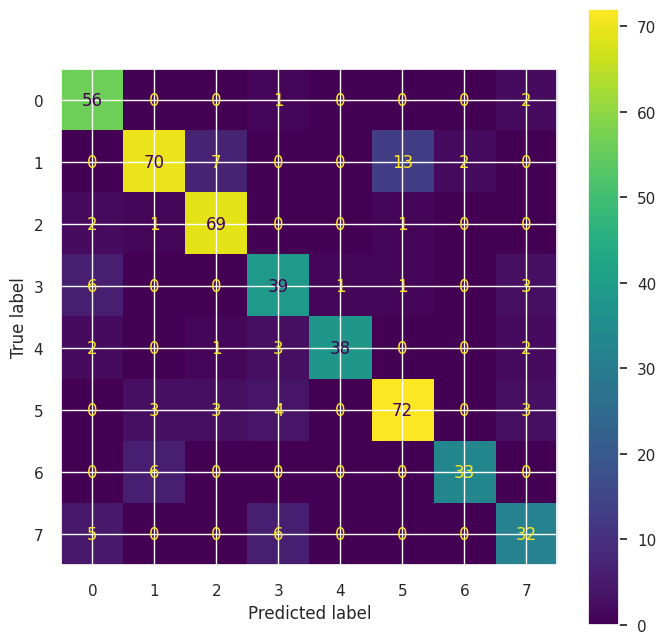

In [ ]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_s, y_test, display_labels=cls, ax=plt.subplot());

A la gràfica es pot veure com una part considerable dels errors són preddiccións de la classe 2 i 5 que haurien de ser de la classe 1. A part d'això es pot veure una distribució prou correcte sense gaire confusió entre classes.

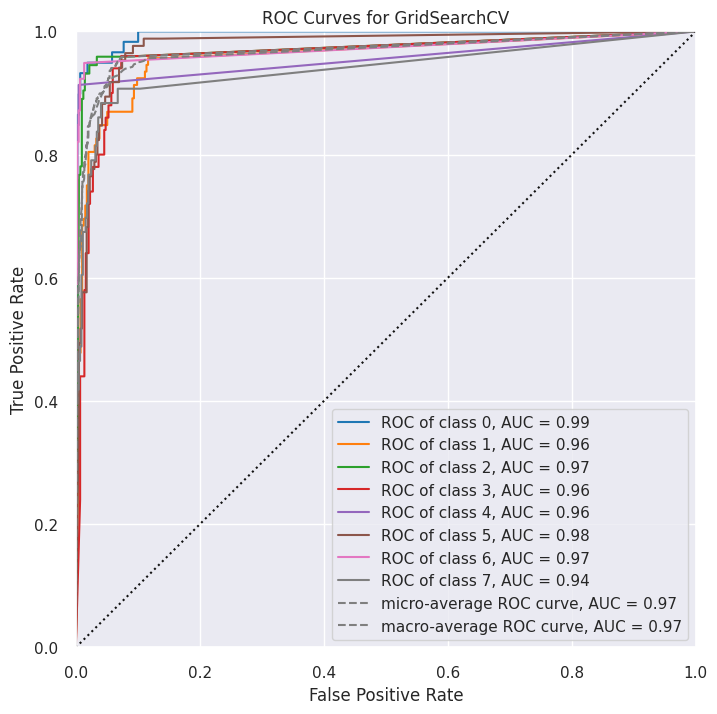

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(knn_gs, X_train_s, y_train, X_test_s, y_test, classes=cls);

### Comparació

In [ ]:
results.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
Logistic,0.877533,0.872690,0.881451,0.862260,0.867828
KNN,0.840529,0.839836,0.846099,0.837339,0.838862
GNB,NaN,0.763860,0.768483,0.759252,0.740661
LDA,NaN,0.657084,0.761598,0.626985,0.623511


Si fem una comparació general, tenim que el pitjor model per les dades de test és el LDA amb un resultat de 0.65, aquest ve seguit del Naïve Bayes, amb un resultat superior encara que seguiex sent baix. Aquests dos models mostren certs problemes de precisió en certes clases, resultant ser models bastant pobres per aquest conjunt de dades.

Per un altra banda podem veure que KNN no acaba de superar a la regressió logística però tot i això obté prou bons resultats amb un test acc de $\approx$ 0.84. Aquest model ha donat un resultat bastant bo encara que la precisió ha sigut més baixa en certes classes.

Finalment tenim la regressió logística, que ha sigut la que millor resultat ha donat per aquest conjunt de dades.

## F:

In [38]:
lda_reduced = LinearDiscriminantAnalysis()
lda_reduced.best_score_ = np.mean(cross_val_score(lda_reduced,X_train_logistic_reduced,y_train,cv=10))
print(lda.best_score_)

0.6053485483620556


In [42]:
lda_model_reduced = LinearDiscriminantAnalysis().fit(X_train_logistic_reduced, y_train)
print(classification_report(y_test, lda_model_reduced.predict(X_test_logistic_reduced), target_names=['0', '1', '2', '3', '4', '5', '6', '7']))
results = save_results(lda_model_reduced, X_test_logistic_reduced, y_test, 'LDA', results)

              precision    recall  f1-score   support

           0       0.36      1.00      0.53        59
           1       0.71      0.76      0.73        92
           2       0.79      0.90      0.84        73
           3       0.54      0.14      0.22        50
           4       1.00      0.57      0.72        46
           5       0.56      0.49      0.53        85
           6       1.00      0.67      0.80        39
           7       0.00      0.00      0.00        43

    accuracy                           0.61       487
   macro avg       0.62      0.57      0.55       487
weighted avg       0.62      0.61      0.58       487



C:\Users\marti.DESKTOP-HBVCDFL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marti.DESKTOP-HBVCDFL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marti.DESKTOP-HBVCDFL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t